# 0. Project Presentation

The project goal is to build a predictive model using machine learning to predict the probability of a device failure. To use that, we have access to nine parameters calculated every day during 92 days for 1164 devices and their status (failure or no). When building this model, we have made sure to minimize false positives and false negatives.

## Import modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

from datetime import date

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, IntSlider, fixed

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

from bokeh.io import output_notebook
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

# 1. Load Data

In [2]:
df = pd.read_csv("predictive_maintenance_2.csv", sep=";")

df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


# 2. Analysis of dataset

## Global Analysis

In [3]:
n_total = len(df["device"].unique())

print("There is {} devices.".format(n_total))

There is 1164 devices.


In [4]:
df.info()

# Looks like the data are complete

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65534 entries, 0 to 65533
Data columns (total 12 columns):
date          65534 non-null object
device        65534 non-null object
failure       65534 non-null int64
attribute1    65534 non-null int64
attribute2    65534 non-null int64
attribute3    65534 non-null int64
attribute4    65534 non-null int64
attribute5    65534 non-null int64
attribute6    65534 non-null int64
attribute7    65534 non-null int64
attribute8    65534 non-null int64
attribute9    65534 non-null int64
dtypes: int64(10), object(2)
memory usage: 6.0+ MB


In [5]:
df.isnull().sum()

# No missing values

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

The dataset has not any missing values.

In [6]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,65534.000000,6.553400e+04,65534.000000,65534.000000,65534.000000,65534.000000,65534.000000,65534.000000,65534.000000,65534.000000
mean,0.000717,1.225403e+08,199.888424,9.689810,1.719275,13.979385,250931.065111,0.213721,0.213721,16.795953
std,0.026771,7.039161e+07,2511.528180,224.492499,19.373035,14.926991,95030.068855,5.341180,5.341180,243.848108
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.155979e+07,0.000000,0.000000,0.000000,8.000000,217505.000000,0.000000,0.000000,0.000000
50%,0.000000,1.231079e+08,0.000000,0.000000,0.000000,10.000000,243995.000000,0.000000,0.000000,0.000000
75%,0.000000,1.835496e+08,0.000000,0.000000,0.000000,12.000000,304949.000000,0.000000,0.000000,0.000000
max,1.000000,2.441386e+08,64784.000000,24929.000000,1074.000000,98.000000,664245.000000,744.000000,744.000000,18701.000000


In [7]:
df.describe(include=['O'])

,date,device
count,65534,65534
unique,93,1164
top,2015-01-02,S1F0S58D
freq,1163,93


In [8]:
df.groupby(["device"])["failure"].sum().value_counts(normalize=False)

0    1117
1      47
Name: failure, dtype: int64

In [9]:
df["failure"].value_counts(normalize=True)*100

0    99.928282
1     0.071718
Name: failure, dtype: float64

The number of failing devices is really low compared to the one of non-failing devices (4% approximately). It is even worst when you consider the number of points with failure = 1 in the dataset (less than 0.1%). Therefore, we are probably facing a problem of unbalanced dataset.

## Data visualization

Pair plot is printed in order to see the correlations between all the features.

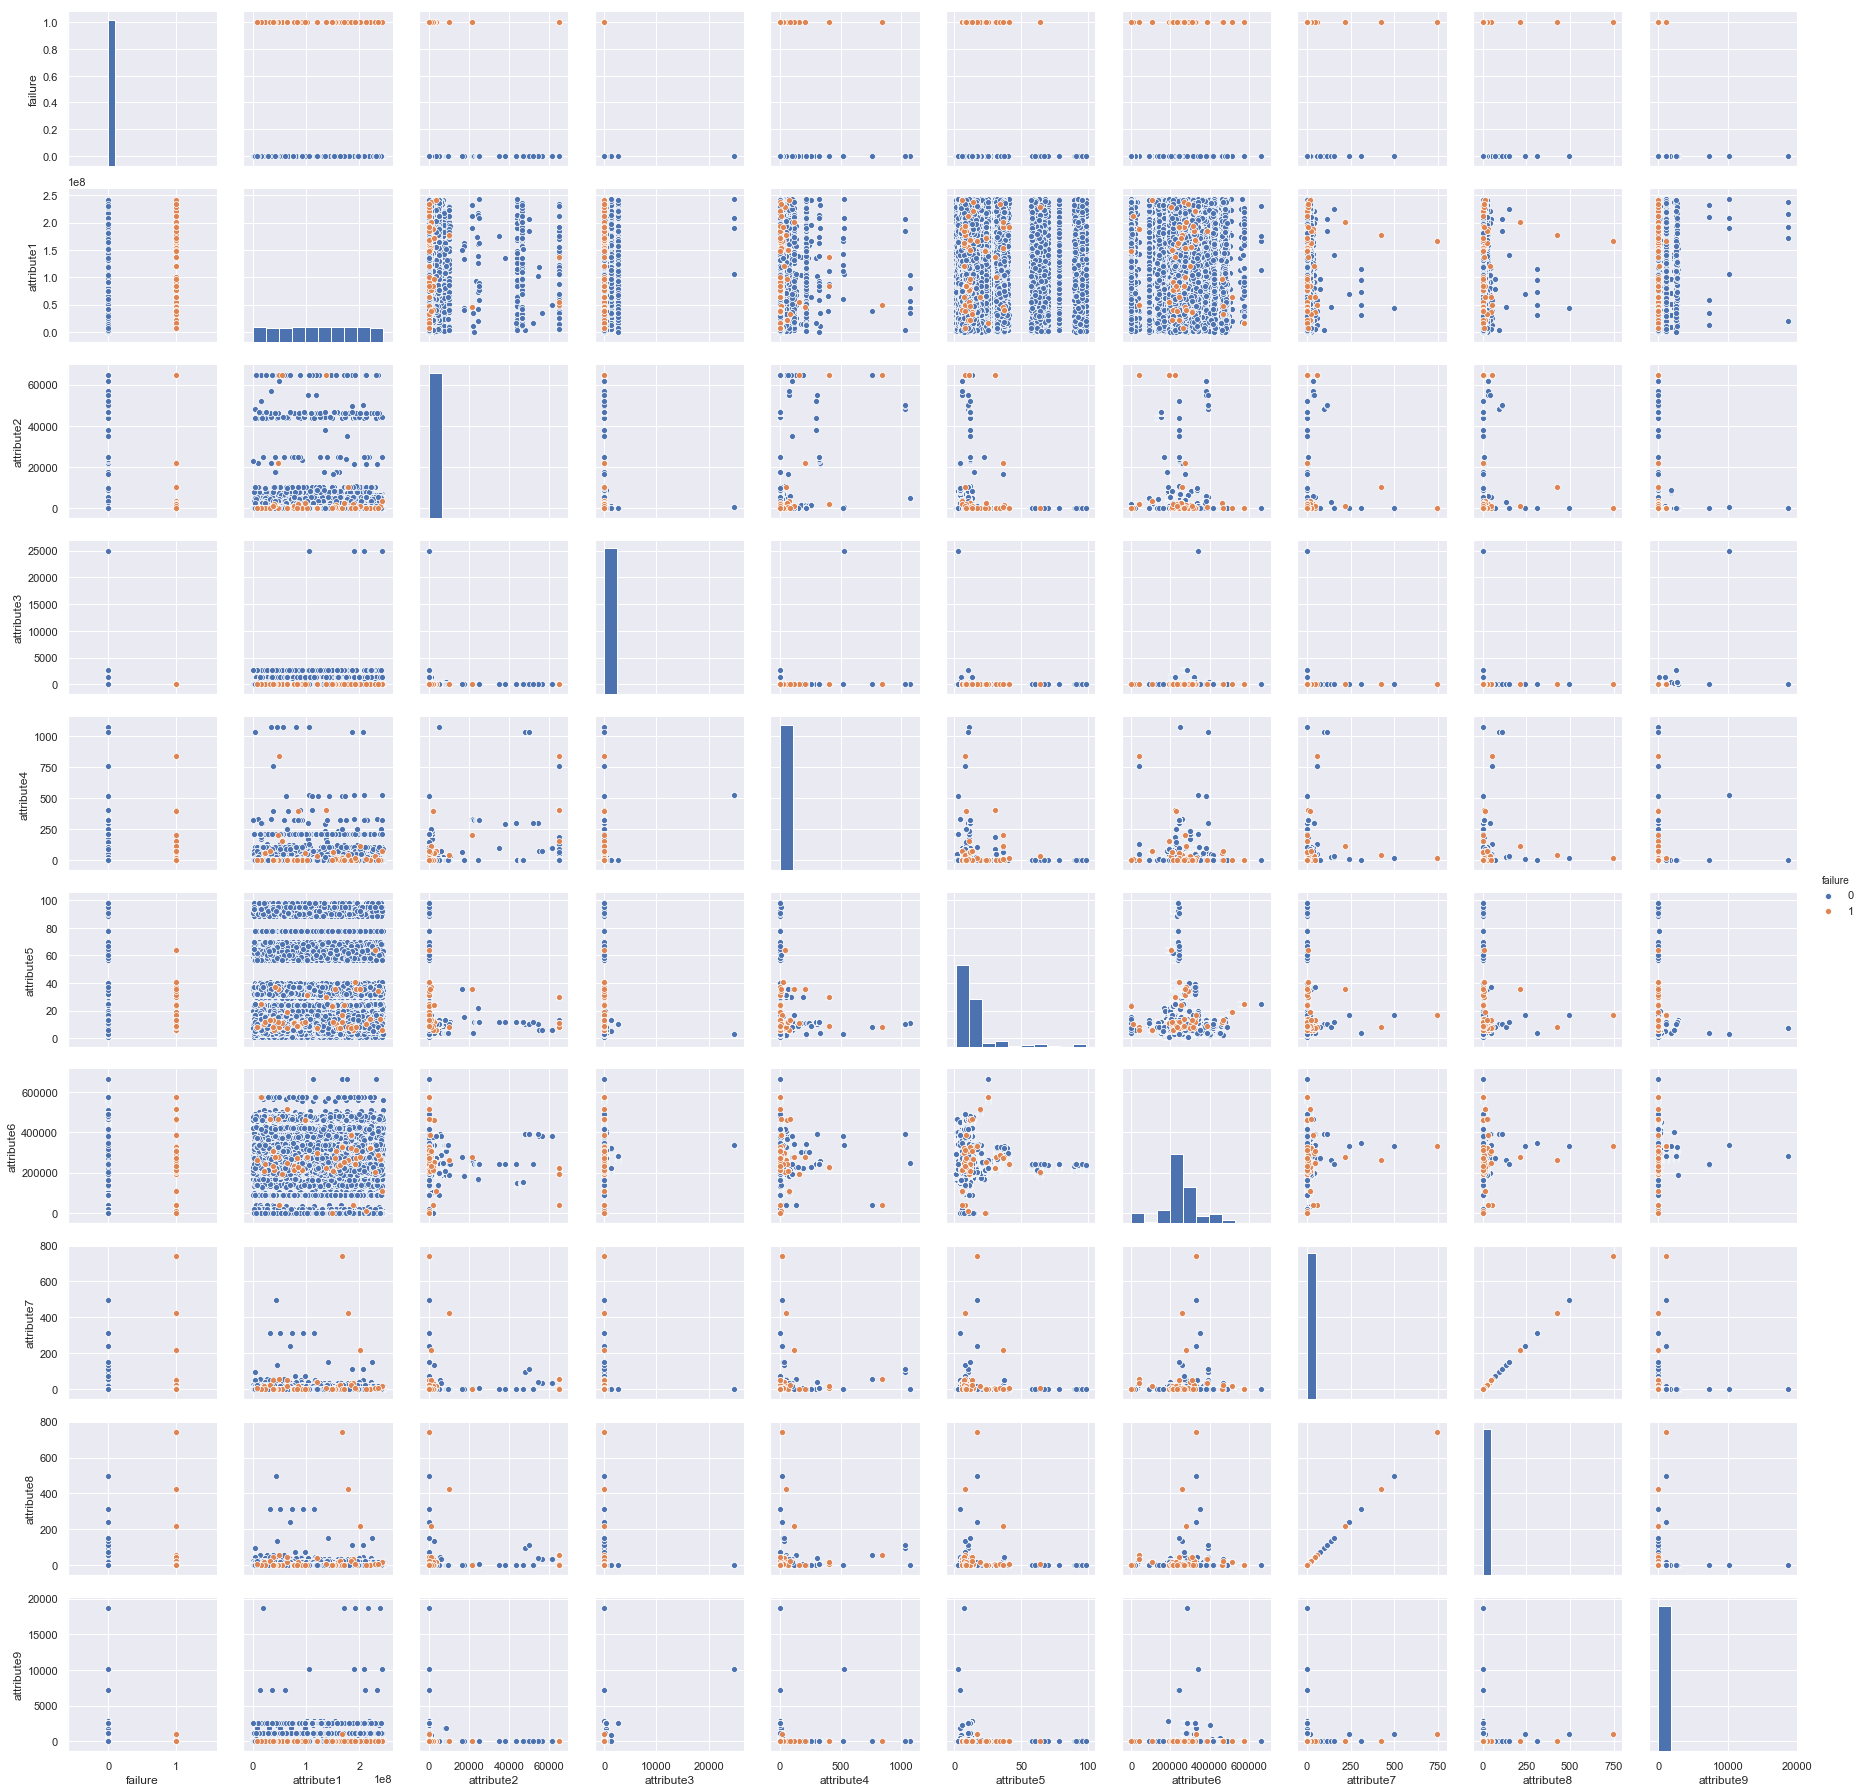

In [10]:
# pair plot to see feature correlations with each other
sns.pairplot(df,hue='failure', diag_kind='hist')

In [11]:
print("There are {} identical between attribute7 et attribute8 (the total number of value is {}).".\
      format(int((df['attribute7']==df['attribute8']).value_counts()),len(df)))

There are 65534 identical between attribute7 et attribute8 (the total number of value is 65534).


The attribute7 and attribute8 are strictly the same. 

In [12]:
# We transform the raw date into the number of days passed since the beginning of datasert

for d in df["date"].unique():
    datetime = date(int(d.split("-")[0]), int(d.split("-")[1]), int(d.split("-")[2]))
    nbDay = (datetime - date(2015, 1, 1)).days
    df.loc[df["date"]==d, "date"] = int(nbDay)

In [13]:
df["date"].max()

92

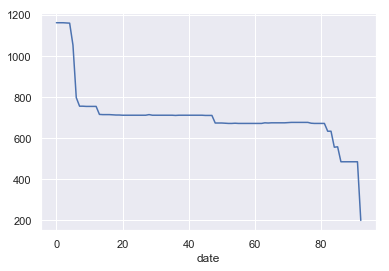

In [14]:
df.groupby('date')['device'].count().plot()

We can see that the number of non-failing devices dramatically falls with the number of days. Obviously the age of the machine is a key parameter and should be considered as an input.

In [15]:
def plot_machine(machine_chosen):
      
    df_machine = df[df["device"]== str(machine_chosen[0])]
    
    fig, axs = plt.subplots(9, 1 , figsize=(20,20))
    color = ["k", "b", "r", "m",
             "xk", "xb", "xr", "xm",
             "ok"]
    
    axs[0].set_title("Plot of machine {}".format(str(machine_chosen[0])))
    
    for i in range(1,10):
        attribute = "attribute" + str(i)
        axs[i-1].plot(df_machine["date"].tolist(),df_machine[attribute].tolist(), color[i-1], label=attribute)
        axs[i-1].legend(loc="upper left")
        
    axs[8].set_xlabel("Number of days")
    plt.show()

In [16]:
failure_machine = df[df["failure"]==1]["device"].tolist()

machine = widgets.SelectMultiple(
    options=sorted(failure_machine),
    value=[sorted(failure_machine)[1]],
    description='machine',
    disabled=False,
)


widgets.interactive(plot_machine, machine_chosen = machine)

interactive(children=(SelectMultiple(description='machine', index=(1,), options=('S1F023H2', 'S1F0CTDN', 'S1F0…

For now we can make some assumptions: 
- This dataset is clean, there is no missing value.
- Date (or number of days spent since the begining) is a key point.
- All attributes are integers. Attribute 8 and 7 are redondants.
- The data set is highly unbalanced, as the failuer class is about 0.1% of unfailure class. We might have to use oversampling or undersampling techniques.
- Attribue7 and 8 seems like exactly same to each other, we can drop one of them.
- The first letters of the devices names seem to be a pattern.

# 3. Data processing

## Deleting useless columns

The first thing to do is to take out the attribute8.

In [17]:
# We take out the attribute 8 redundant with attribute7
df.drop('attribute8',axis=1,inplace=True)

In order to reduce the volume of the class unfailure, only the last line of every device is kept. This way we keep the most important data for the failing machine and we keep a huge amount of data for the unfailing devices.

In [18]:
df1 = df.groupby('device').agg({'date':max})

df1=df1.reset_index()

df=df.reset_index(drop=True) 

df= pd.merge(df1,df,how='left',on=['device','date'])

df.shape

(1164, 11)

In [19]:
df.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,S1F01085,5,0,128832128,56,0,52,6,409404,0,7
1,S1F0166B,5,0,7441792,0,3,0,6,404786,0,0
2,S1F01E6Y,47,0,147350000,0,0,0,12,259491,0,0
3,S1F01JE0,5,0,185424928,0,0,0,6,412151,0,0
4,S1F01R2B,92,0,178313152,0,0,0,17,329804,0,3


The first four letters of the device names seem to repeat a lot in the dataset. It might be a code to define differents types of devices.

In [20]:
Id = df.device.values.tolist()
newId = []

for i in Id:
    i = i[:4]
    newId.append(i)
    
df.device=newId
df.device.value_counts()

S1F0    387
W1F0    282
Z1F0    149
S1F1    139
W1F1    137
Z1F1     67
Z1F2      3
Name: device, dtype: int64

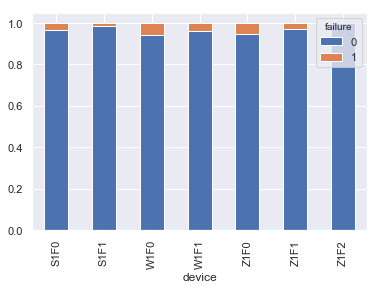

In [21]:
# Repartition of failing machines in the different types of devices

dev=pd.crosstab(df['device'],df['failure']) 
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.show() 

In [22]:
for device in df["device"].unique():
    dfDevice= df.loc[df["device"]==device]["failure"]
    print("For the device {} {}% of machine had a failure.".format(device, round(dfDevice.sum()/len(dfDevice)*100),2))

For the device S1F0 4.0% of machine had a failure.
For the device S1F1 1.0% of machine had a failure.
For the device W1F0 6.0% of machine had a failure.
For the device W1F1 4.0% of machine had a failure.
For the device Z1F0 5.0% of machine had a failure.
For the device Z1F1 3.0% of machine had a failure.
For the device Z1F2 0.0% of machine had a failure.


The devices S1F0, W1F1 and W1F0 seem to have more chance to have failures. On the contrary, Z1F2 machines seem to be more resistant. Therefore, the four letters of the devices are going to be inputed in the model. 

Now, they need to be transformed in numbers to be inputed in the model.

In [23]:
i=0
for device in df["device"].unique():
    df.loc[df["device"]==device,"device"] = i
    i+=1
df.head()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,0,5,0,128832128,56,0,52,6,409404,0,7
1,0,5,0,7441792,0,3,0,6,404786,0,0
2,0,47,0,147350000,0,0,0,12,259491,0,0
3,0,5,0,185424928,0,0,0,6,412151,0,0
4,0,92,0,178313152,0,0,0,17,329804,0,3


## Attribute data standartization

The attribute datas need to be standartized in order to be understood better by the model. Before doing that, we split the dataset in two pieces: training and validation data. We choose a basic repartition of 70% training and 30% validation. Of course, the separation is made randomly.

In [24]:
# We are going to choose the training and testing data set 
Y_total = df["failure"]
df_train = df.drop(["failure"], axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(df_train, Y_total, test_size=0.3, random_state=42)

In [25]:
std = StandardScaler()
X_train = pd.DataFrame(std.fit_transform(X_train))
X_validation = pd.DataFrame(std.fit_transform(X_validation))

In [26]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9
count,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02
mean,-2.190440e-16,1.069306e-16,1.067260e-17,-3.396478e-16,4.468341e-16,2.220446e-16,-4.023536e-17,-6.383100e-17,-1.897199e-16,5.701145e-17
std,1.000615e+00,1.000615e+00,1.000615e+00,1.000615e+00,1.000615e+00,1.000615e+00,1.000615e+00,1.000615e+00,1.000615e+00,1.000615e+00
min,-1.108222e+00,-1.395543e+00,-1.709076e+00,-1.197250e-01,-4.596471e-02,-1.263319e-01,-9.013379e-01,-2.683049e+00,-7.140287e-02,-7.964728e-02
25%,-1.108222e+00,-1.319606e+00,-8.763573e-01,-1.197250e-01,-4.596471e-02,-1.263319e-01,-4.238830e-01,-4.687341e-01,-7.140287e-02,-7.964728e-02
50%,1.224638e-01,6.547652e-01,-3.508851e-02,-1.197250e-01,-4.596471e-02,-1.263319e-01,-2.647313e-01,-8.649997e-02,-7.140287e-02,-7.964728e-02
75%,7.378069e-01,8.572648e-01,9.153935e-01,-1.197250e-01,-4.596471e-02,-1.263319e-01,-2.600389e-02,6.470676e-01,-7.140287e-02,-7.840544e-02
max,2.583836e+00,8.825773e-01,1.684897e+00,1.280134e+01,2.825532e+01,1.792890e+01,6.817516e+00,3.370559e+00,2.384603e+01,2.314406e+01


In [27]:
pd.DataFrame(X_validation).describe()

,0,1,2,3,4,5,6,7,8,9
count,3.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02
mean,2.410770e-17,-8.564578e-18,-3.869920e-17,2.430595e-16,-7.914304e-17,1.938132e-16,1.332268e-17,-1.107051e-16,-1.095949e-16,1.324337e-17
std,1.001432e+00,1.001432e+00,1.001432e+00,1.001432e+00,1.001432e+00,1.001432e+00,1.001432e+00,1.001432e+00,1.001432e+00,1.001432e+00
min,-1.088986e+00,-1.280004e+00,-1.764944e+00,-1.244072e-01,-1.304855e-01,-1.142357e-01,-8.252313e-01,-2.632607e+00,-1.282526e-01,-9.640112e-02
25%,-1.088986e+00,-1.255031e+00,-8.653867e-01,-1.244072e-01,-1.304855e-01,-1.142357e-01,-4.059064e-01,-4.723385e-01,-1.282526e-01,-9.640112e-02
50%,1.878821e-01,6.929105e-01,6.458067e-02,-1.244072e-01,-1.304855e-01,-1.142357e-01,-2.381765e-01,-1.118905e-01,-1.282526e-01,-9.640112e-02
75%,8.263163e-01,8.926994e-01,8.303376e-01,-1.244072e-01,-1.304855e-01,-1.142357e-01,1.341839e-02,6.472443e-01,-1.282526e-01,-9.163732e-02
max,2.103185e+00,9.176730e-01,1.695474e+00,1.366871e+01,1.197632e+01,1.650625e+01,6.974210e+00,4.212196e+00,1.646556e+01,1.432203e+01


In [28]:
y_train.value_counts()

0    784
1     30
Name: failure, dtype: int64

In [29]:
y_validation.value_counts()

0    333
1     17
Name: failure, dtype: int64

## Naive attempt to build a model

Now that we have our dataset, we can try to build a model. The problem is that the data are still unbalanced so we know in advance that the result is going to be dispapointing. 

I have build a simple model of Logistic Regression.

In [30]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_validation)

Y_train_pred = logreg.predict(X_train)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_LR = f1_score(y_validation,Y_pred)
score_train_LR = f1_score(y_train, Y_train_pred)

accuracy_train_LR = accuracy_score(y_train, Y_train_pred)
accuracy_validation_LR = accuracy_score(y_validation, Y_pred)

print("The F1 score of the model with the train data is {}"\
    .format(score_train_LR*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_LR*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(accuracy_train_LR*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(accuracy_validation_LR*100))


The matrix of confusion is: 
 [327     6
  13     4]
--------------------------------------
The pourcentage of true positive is 0.011428571428571429
The pourcentage of true negative is 0.9342857142857143
The pourcentage of false positive is 0.017142857142857144
The pourcentage of false negative is 0.037142857142857144
--------------------------------------
The F1 score of the model with the train data is 27.77777777777778
The F1 score of the model with the validation data is 29.629629629629633
--------------------------------------
The mean accuracy of the model with the train data is 96.80589680589681
The mean accuracy of the model with the validation data is 94.57142857142857


As expected the model has a high accuracy but a weak F1 Score. Indeed, the volume of unfailing cases in the dataset does not allow the model to learn well. In order to resolve this problem, the dataset is going to be reshaped. Two methods are going to be tested: 
- Undersampling: We are going to artifically reduce the volume of unfailure devices in the training dataset.
- Oversampling: We are going to artifically increase the volume of failure devices in the training dataset.

# Reshape method 

## Oversampling method

In this section, we are going to artificially increase the volume of failing devices, this method should help the model. 

In [31]:
ros = RandomOverSampler(sampling_strategy=  1, random_state=42)

nb1 = y_train.sum()
nb0 = len(y_train)-y_train.sum()

X_train_os, y_train_os = ros.fit_sample(X_train, y_train)
X_train.shape
#X_train_os = pd.DataFrame(X_train)


(814, 10)

In [32]:
print("Number of class 1 passed from {} to {}".format(nb1, y_train_os.sum()))
print("Number of class 0 passed from {} to {}".format(nb0, len(y_train_os)-y_train_os.sum()))

Number of class 1 passed from 30 to 784
Number of class 0 passed from 784 to 784


In [33]:
logreg = LogisticRegression()
logreg.fit(X_train_os, y_train_os)

Y_pred = logreg.predict(X_validation)

Y_train_pred = logreg.predict(X_train_os)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_LR = f1_score(y_validation,Y_pred)
score_train_LR = f1_score(y_train_os, Y_train_pred)

acc_validation_LR = 1- (abs(y_validation-Y_pred).mean())
acc_train_LR = 1- (abs(y_train_os-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_LR*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_LR*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_LR*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_LR*100))


The matrix of confusion is: 
 [306     27
  7     10]
--------------------------------------
The pourcentage of true positive is 0.02857142857142857
The pourcentage of true negative is 0.8742857142857143
The pourcentage of false positive is 0.07714285714285714
The pourcentage of false negative is 0.02
--------------------------------------
The F1 score of the model with the train data is 81.37457044673539
The F1 score of the model with the validation data is 37.03703703703704
--------------------------------------
The mean accuracy of the model with the train data is 82.71683673469387
The mean accuracy of the model with the validation data is 90.28571428571428


In [34]:
# RANDOM FOREST MODEL 

random_forest = RandomForestClassifier()
random_forest.fit(X_train_os, y_train_os)
Y_pred = random_forest.predict(X_validation)

Y_train_pred = random_forest.predict(X_train_os)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_RF = f1_score(y_validation,Y_pred)
score_train_RF = f1_score(y_train_os, Y_train_pred)

acc_validation_RF = 1- (abs(y_validation-Y_pred).mean())
acc_train_RF = 1- (abs(y_train_os-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_RF*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_RF*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_RF*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_RF*100))



The matrix of confusion is: 
 [332     1
  11     6]
--------------------------------------
The pourcentage of true positive is 0.017142857142857144
The pourcentage of true negative is 0.9485714285714286
The pourcentage of false positive is 0.002857142857142857
The pourcentage of false negative is 0.03142857142857143
--------------------------------------
The F1 score of the model with the train data is 100.0
The F1 score of the model with the validation data is 50.0
--------------------------------------
The mean accuracy of the model with the train data is 100.0
The mean accuracy of the model with the validation data is 96.57142857142857


In [35]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train_os, y_train_os)

Y_pred = svc.predict(X_validation)
Y_train_pred = svc.predict(X_train_os)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_svc = f1_score(y_validation,Y_pred)
score_train_svc = f1_score(y_train_os, Y_train_pred)

acc_validation_svc = 1- (abs(y_validation-Y_pred).mean())
acc_train_svc = 1- (abs(y_train_os-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_svc*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_svc*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_svc*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_svc*100))

The matrix of confusion is: 
 [318     15
  9     8]
--------------------------------------
The pourcentage of true positive is 0.022857142857142857
The pourcentage of true negative is 0.9085714285714286
The pourcentage of false positive is 0.04285714285714286
The pourcentage of false negative is 0.025714285714285714
--------------------------------------
The F1 score of the model with the train data is 96.61774090619016
The F1 score of the model with the validation data is 40.0
--------------------------------------
The mean accuracy of the model with the train data is 96.61989795918367
The mean accuracy of the model with the validation data is 93.14285714285714


In [36]:
#KNN

knn = KNeighborsClassifier()
knn.fit(X_train_os, y_train_os)
Y_pred = knn.predict(X_validation)
Y_train_pred = knn.predict(X_train_os)

#acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
#acc_knn

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_knn = f1_score(y_validation,Y_pred)
score_train_knn = f1_score(y_train_os, Y_train_pred)

acc_validation_knn = 1- (abs(y_validation-Y_pred).mean())
acc_train_knn = 1- (abs(y_train_os-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_knn*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_knn*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_knn*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_knn*100))

The matrix of confusion is: 
 [320     13
  10     7]
--------------------------------------
The pourcentage of true positive is 0.02
The pourcentage of true negative is 0.9142857142857143
The pourcentage of false positive is 0.037142857142857144
The pourcentage of false negative is 0.02857142857142857
--------------------------------------
The F1 score of the model with the train data is 99.49238578680203
The F1 score of the model with the validation data is 37.83783783783783
--------------------------------------
The mean accuracy of the model with the train data is 99.48979591836735
The mean accuracy of the model with the validation data is 93.42857142857143


In [37]:
# NR

early = EarlyStopping(monitor="val_loss", mode="min", patience=100)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, early]

model = Sequential()
model.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_os, y_train_os, \
          validation_data=(X_validation, y_validation), \
          epochs=150, batch_size=3,\
          callbacks=callbacks_list)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1568 samples, validate on 350 samples
Epoch 1/150
1568/1568 [==============================] - 1s 470us/step - loss: 0.6468 - acc: 0.6352 - val_loss: 0.5785 - val_acc: 0.8086

Epoch 00001: val_loss improved from inf to 0.57847, saving model to model.hdf5
Epoch 2/150
1568/1568 [==============================] - 0s 288us/step - loss: 0.4758 - acc: 0.7972 - val_loss: 0.4870 - val_acc: 0.8943

Epoch 00002: val_loss improved from 0.57847 to 0.48698, saving model to model.hdf5
Epoch 3/150
1568/1568 [==============================] - 0s 288us/step - loss: 0.3908 - acc: 0.8565 - val_loss: 0.4003 - val_acc: 0.9286

Epoch 00003: val_loss improved from 0.48698 to 0.40033, saving model to model.hdf5
Epoch 4/150
1568/1568 [==============================] - 0s 286us/step - loss: 0.3245 - acc: 0.8750 - val_loss: 0.3525 - val_acc: 0.9343

Epoch 00004: val_loss improved from 

1568/1568 [==============================] - 0s 303us/step - loss: 0.0481 - acc: 0.9936 - val_loss: 0.4523 - val_acc: 0.9229

Epoch 00040: val_loss did not improve from 0.34430
Epoch 41/150
1568/1568 [==============================] - 0s 279us/step - loss: 0.0463 - acc: 0.9943 - val_loss: 0.4542 - val_acc: 0.9314

Epoch 00041: val_loss did not improve from 0.34430
Epoch 42/150
1568/1568 [==============================] - 0s 286us/step - loss: 0.0448 - acc: 0.9936 - val_loss: 0.4544 - val_acc: 0.9286

Epoch 00042: val_loss did not improve from 0.34430
Epoch 43/150
1568/1568 [==============================] - 0s 297us/step - loss: 0.0430 - acc: 0.9936 - val_loss: 0.4575 - val_acc: 0.9343

Epoch 00043: val_loss did not improve from 0.34430
Epoch 44/150
1568/1568 [==============================] - 0s 317us/step - loss: 0.0417 - acc: 0.9930 - val_loss: 0.4595 - val_acc: 0.9314

Epoch 00044: val_loss did not improve from 0.34430
Epoch 45/150
1568/1568 [==============================] - 1s 32

1568/1568 [==============================] - 0s 305us/step - loss: 0.0138 - acc: 0.9968 - val_loss: 0.5694 - val_acc: 0.9371

Epoch 00083: val_loss did not improve from 0.34430
Epoch 84/150
1568/1568 [==============================] - 0s 278us/step - loss: 0.0135 - acc: 0.9987 - val_loss: 0.5854 - val_acc: 0.9343

Epoch 00084: val_loss did not improve from 0.34430
Epoch 85/150
1568/1568 [==============================] - 0s 292us/step - loss: 0.0134 - acc: 0.9981 - val_loss: 0.5816 - val_acc: 0.9371

Epoch 00085: val_loss did not improve from 0.34430
Epoch 86/150
1568/1568 [==============================] - 0s 294us/step - loss: 0.0129 - acc: 0.9981 - val_loss: 0.5834 - val_acc: 0.9371

Epoch 00086: val_loss did not improve from 0.34430
Epoch 87/150
1568/1568 [==============================] - 0s 286us/step - loss: 0.0124 - acc: 0.9987 - val_loss: 0.5984 - val_acc: 0.9286

Epoch 00087: val_loss did not improve from 0.34430
Epoch 88/150
1568/1568 [==============================] - 0s 28

In [38]:
Y_train_pred = model.predict(X_train_os)
Y_train_pred = (Y_train_pred>0.5)

Y_pred = model.predict(X_validation)
Y_pred = (Y_pred>0.5)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_rnn = f1_score(y_validation,Y_pred)
score_train_rnn = f1_score(y_train_os, Y_train_pred)

score, acc_train_rnn =model.evaluate(X_train_os, y_train_os)
score_train,acc_validation_rnn = model.evaluate(X_validation, y_validation)


print("The F1 score of the model with the train data is {}"\
    .format(score_train_rnn*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_rnn*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_rnn*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_rnn*100))



The matrix of confusion is: 
 [320     13
  8     9]
--------------------------------------
The pourcentage of true positive is 0.025714285714285714
The pourcentage of true negative is 0.9142857142857143
The pourcentage of false positive is 0.037142857142857144
The pourcentage of false negative is 0.022857142857142857
--------------------------------------
350/350 [==============================] - 0s 34us/step
The F1 score of the model with the train data is 99.87261146496816
The F1 score of the model with the validation data is 46.15384615384615
--------------------------------------
The mean accuracy of the model with the train data is 99.87244897959184
The mean accuracy of the model with the validation data is 93.99999976158142


In [39]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Random Forest','Linear SVC',"RNN"],
    'F1 Score': [score_validation_knn*100, score_validation_LR*100, score_validation_RF*100, 
              score_validation_svc*100,score_validation_rnn*100],
    'Accuracy': [acc_validation_knn*100, acc_validation_LR*100, acc_validation_RF*100, acc_validation_svc*100, \
                 acc_validation_rnn*100]})
models.sort_values(by='F1 Score', ascending=False)

,Model,F1 Score,Accuracy
2,Random Forest,50.000000,96.571429
4,RNN,46.153846,94.000000
3,Linear SVC,40.000000,93.142857
0,KNN,37.837838,93.428571
1,Logistic Regression,37.037037,90.285714


The result are far better than previously, now let's see if they are better with undersampling.

## Undersampling method

In this section, we are going to artificially decrease the volume of unfailing devices, this method should help the model. 

In [40]:
rus = RandomUnderSampler(random_state=42)

nb1 = y_train.sum()
nb0 = len(y_train)-y_train.sum()

X_train_us, y_train_us = rus.fit_sample(X_train, y_train)
X_train.shape
X_train = pd.DataFrame(X_train)

In [41]:
print("Number of class 1 passed from {} to {}".format(nb1, y_train_us.sum()))
print("Number of class 0 passed from {} to {}".format(nb0, len(y_train_us)-y_train_us.sum()))

Number of class 1 passed from 30 to 30
Number of class 0 passed from 784 to 30


In [42]:
logreg = LogisticRegression()
logreg.fit(X_train_us, y_train_us)

Y_pred = logreg.predict(X_validation)

Y_train_pred = logreg.predict(X_train_us)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_LR = f1_score(y_validation,Y_pred)
score_train_LR = f1_score(y_train_us, Y_train_pred)

acc_validation_LR = 1- (abs(y_validation-Y_pred).mean())
acc_train_LR = 1- (abs(y_train_us-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_LR*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_LR*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_LR*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_LR*100))


The matrix of confusion is: 
 [280     53
  6     11]
--------------------------------------
The pourcentage of true positive is 0.03142857142857143
The pourcentage of true negative is 0.8
The pourcentage of false positive is 0.15142857142857144
The pourcentage of false negative is 0.017142857142857144
--------------------------------------
The F1 score of the model with the train data is 82.75862068965519
The F1 score of the model with the validation data is 27.160493827160494
--------------------------------------
The mean accuracy of the model with the train data is 83.33333333333334
The mean accuracy of the model with the validation data is 83.14285714285714


In [43]:
# RANDOM FOREST MODEL 

random_forest = RandomForestClassifier()
random_forest.fit(X_train_us, y_train_us)
Y_pred = random_forest.predict(X_validation)

Y_train_pred = random_forest.predict(X_train_us)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_RF = f1_score(y_validation,Y_pred)
score_train_RF = f1_score(y_train_us, Y_train_pred)

acc_validation_RF = 1- (abs(y_validation-Y_pred).mean())
acc_train_RF = 1- (abs(y_train_us-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_RF*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_RF*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_RF*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_RF*100))



The matrix of confusion is: 
 [310     23
  4     13]
--------------------------------------
The pourcentage of true positive is 0.037142857142857144
The pourcentage of true negative is 0.8857142857142857
The pourcentage of false positive is 0.06571428571428571
The pourcentage of false negative is 0.011428571428571429
--------------------------------------
The F1 score of the model with the train data is 100.0
The F1 score of the model with the validation data is 49.056603773584904
--------------------------------------
The mean accuracy of the model with the train data is 100.0
The mean accuracy of the model with the validation data is 92.28571428571428


In [44]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train_us, y_train_us)

Y_pred = svc.predict(X_validation)
Y_train_pred = svc.predict(X_train_us)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_svc = f1_score(y_validation,Y_pred)
score_train_svc = f1_score(y_train_us, Y_train_pred)

acc_validation_svc = 1- (abs(y_validation-Y_pred).mean())
acc_train_svc = 1- (abs(y_train_us-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_svc*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_svc*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_svc*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_svc*100))

The matrix of confusion is: 
 [287     46
  6     11]
--------------------------------------
The pourcentage of true positive is 0.03142857142857143
The pourcentage of true negative is 0.82
The pourcentage of false positive is 0.13142857142857142
The pourcentage of false negative is 0.017142857142857144
--------------------------------------
The F1 score of the model with the train data is 75.0
The F1 score of the model with the validation data is 29.729729729729726
--------------------------------------
The mean accuracy of the model with the train data is 76.66666666666666
The mean accuracy of the model with the validation data is 85.14285714285714


In [45]:
#KNN

knn = KNeighborsClassifier()
knn.fit(X_train_us, y_train_us)
Y_pred = knn.predict(X_validation)
Y_train_pred = knn.predict(X_train_us)

#acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
#acc_knn

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_knn = f1_score(y_validation,Y_pred)
score_train_knn = f1_score(y_train_us, Y_train_pred)

acc_validation_knn = 1- (abs(y_validation-Y_pred).mean())
acc_train_knn = 1- (abs(y_train_us-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_knn*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_knn*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_knn*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_knn*100))

The matrix of confusion is: 
 [256     77
  7     10]
--------------------------------------
The pourcentage of true positive is 0.02857142857142857
The pourcentage of true negative is 0.7314285714285714
The pourcentage of false positive is 0.22
The pourcentage of false negative is 0.02
--------------------------------------
The F1 score of the model with the train data is 73.68421052631578
The F1 score of the model with the validation data is 19.230769230769234
--------------------------------------
The mean accuracy of the model with the train data is 75.0
The mean accuracy of the model with the validation data is 76.0


In [46]:
# NR

early = EarlyStopping(monitor="val_loss", mode="min", patience=100)
checkpoint = ModelCheckpoint("model.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, early]

model = Sequential()
model.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_us, y_train_us, \
          validation_data=(X_validation, y_validation), \
          epochs=150, batch_size=3,\
          callbacks=callbacks_list)

Train on 60 samples, validate on 350 samples
Epoch 1/150
60/60 [==============================] - 0s 5ms/step - loss: 0.6922 - acc: 0.6000 - val_loss: 0.5200 - val_acc: 0.8886

Epoch 00001: val_loss improved from inf to 0.51999, saving model to model.hdf5
Epoch 2/150
60/60 [==============================] - 0s 840us/step - loss: 0.6567 - acc: 0.6000 - val_loss: 0.5224 - val_acc: 0.8771

Epoch 00002: val_loss did not improve from 0.51999
Epoch 3/150
60/60 [==============================] - 0s 864us/step - loss: 0.6327 - acc: 0.6000 - val_loss: 0.5207 - val_acc: 0.8714

Epoch 00003: val_loss did not improve from 0.51999
Epoch 4/150
60/60 [==============================] - 0s 1ms/step - loss: 0.6137 - acc: 0.6167 - val_loss: 0.5231 - val_acc: 0.8800

Epoch 00004: val_loss did not improve from 0.51999
Epoch 5/150
60/60 [==============================] - 0s 1ms/step - loss: 0.5960 - acc: 0.6500 - val_loss: 0.5208 - val_acc: 0.8771

Epoch 00005: val_loss did not improve from 0.51999
Epoch 6/

60/60 [==============================] - 0s 2ms/step - loss: 0.3798 - acc: 0.8167 - val_loss: 0.4378 - val_acc: 0.8914

Epoch 00041: val_loss did not improve from 0.43340
Epoch 42/150
60/60 [==============================] - 0s 925us/step - loss: 0.3762 - acc: 0.8167 - val_loss: 0.4348 - val_acc: 0.8886

Epoch 00042: val_loss did not improve from 0.43340
Epoch 43/150
60/60 [==============================] - 0s 866us/step - loss: 0.3730 - acc: 0.8333 - val_loss: 0.4430 - val_acc: 0.8914

Epoch 00043: val_loss did not improve from 0.43340
Epoch 44/150
60/60 [==============================] - 0s 765us/step - loss: 0.3691 - acc: 0.8167 - val_loss: 0.4421 - val_acc: 0.8886

Epoch 00044: val_loss did not improve from 0.43340
Epoch 45/150
60/60 [==============================] - 0s 749us/step - loss: 0.3654 - acc: 0.8500 - val_loss: 0.4390 - val_acc: 0.8914

Epoch 00045: val_loss did not improve from 0.43340
Epoch 46/150
60/60 [==============================] - 0s 788us/step - loss: 0.3613 - 

60/60 [==============================] - 0s 840us/step - loss: 0.2528 - acc: 0.9167 - val_loss: 0.4347 - val_acc: 0.9057

Epoch 00085: val_loss did not improve from 0.43340
Epoch 86/150
60/60 [==============================] - 0s 823us/step - loss: 0.2497 - acc: 0.9333 - val_loss: 0.4379 - val_acc: 0.9086

Epoch 00086: val_loss did not improve from 0.43340
Epoch 87/150
60/60 [==============================] - 0s 835us/step - loss: 0.2480 - acc: 0.9333 - val_loss: 0.4373 - val_acc: 0.9086

Epoch 00087: val_loss did not improve from 0.43340
Epoch 88/150
60/60 [==============================] - 0s 743us/step - loss: 0.2451 - acc: 0.9333 - val_loss: 0.4377 - val_acc: 0.9086

Epoch 00088: val_loss did not improve from 0.43340
Epoch 89/150
60/60 [==============================] - 0s 876us/step - loss: 0.2440 - acc: 0.9333 - val_loss: 0.4346 - val_acc: 0.9086

Epoch 00089: val_loss did not improve from 0.43340
Epoch 90/150
60/60 [==============================] - 0s 838us/step - loss: 0.2413 

60/60 [==============================] - 0s 787us/step - loss: 0.1769 - acc: 0.9667 - val_loss: 0.4732 - val_acc: 0.9029

Epoch 00129: val_loss did not improve from 0.43340
Epoch 130/150
60/60 [==============================] - 0s 797us/step - loss: 0.1760 - acc: 0.9667 - val_loss: 0.4753 - val_acc: 0.9029

Epoch 00130: val_loss did not improve from 0.43340
Epoch 131/150
60/60 [==============================] - 0s 807us/step - loss: 0.1751 - acc: 0.9667 - val_loss: 0.4766 - val_acc: 0.9000

Epoch 00131: val_loss did not improve from 0.43340
Epoch 132/150
60/60 [==============================] - 0s 803us/step - loss: 0.1735 - acc: 0.9667 - val_loss: 0.4721 - val_acc: 0.9029

Epoch 00132: val_loss did not improve from 0.43340
Epoch 133/150
60/60 [==============================] - 0s 728us/step - loss: 0.1723 - acc: 0.9667 - val_loss: 0.4720 - val_acc: 0.9029

Epoch 00133: val_loss did not improve from 0.43340
Epoch 134/150
60/60 [==============================] - 0s 827us/step - loss: 0.

In [47]:
Y_train_pred = model.predict(X_train_us)
Y_train_pred = (Y_train_pred>0.5)

Y_pred = model.predict(X_validation)
Y_pred = (Y_pred>0.5)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                       matrix_confusion[1],
                                                                       matrix_confusion[2],
                                                                       matrix_confusion[3]))

print("--------------------------------------")

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_rnn = f1_score(y_validation,Y_pred)
score_train_rnn = f1_score(y_train_us, Y_train_pred)

score, acc_train_rnn =model.evaluate(X_train_us, y_train_us)
score_train,acc_validation_rnn = model.evaluate(X_validation, y_validation)


print("The F1 score of the model with the train data is {}"\
    .format(score_train_rnn*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_rnn*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(acc_train_rnn*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(acc_validation_rnn*100))



The matrix of confusion is: 
 [303     30
  5     12]
--------------------------------------
The pourcentage of true positive is 0.03428571428571429
The pourcentage of true negative is 0.8657142857142858
The pourcentage of false positive is 0.08571428571428572
The pourcentage of false negative is 0.014285714285714285
--------------------------------------
350/350 [==============================] - 0s 19us/step
The F1 score of the model with the train data is 96.55172413793103
The F1 score of the model with the validation data is 40.67796610169491
--------------------------------------
The mean accuracy of the model with the train data is 96.66666547457378
The mean accuracy of the model with the validation data is 90.0000000340598


In [48]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Random Forest','Linear SVC',"RNN"],
    'F1 Score': [score_validation_knn*100, score_validation_LR*100, score_validation_RF*100, 
              score_validation_svc*100,score_validation_rnn*100],
    'Accuracy': [acc_validation_knn*100, acc_validation_LR*100, acc_validation_RF*100, acc_validation_svc*100, \
                 acc_validation_rnn*100]})
models.sort_values(by='F1 Score', ascending=False)

,Model,F1 Score,Accuracy
2,Random Forest,49.056604,92.285714
4,RNN,40.677966,90.000000
3,Linear SVC,29.729730,85.142857
1,Logistic Regression,27.160494,83.142857
0,KNN,19.230769,76.000000


Oversampling seems to be more efficient for this problem, we are going to use this strategy.

# 4. Selection and training of the model

Random Forest Classifier is the best model we have so far, it has been optimized for this problem, the result are bellow:

## Optimized Random Forest model  

In [49]:
# RANDOM FOREST MODEL

def RF(X_train_os, y_train_os, X_validation, y_validation):
    
    random_forest = RandomForestClassifier(n_estimators=5000, random_state=21)

    random_forest.fit(X_train_os, y_train_os)
    Y_pred = random_forest.predict(X_validation).astype(int)
    
    Y_train_pred = random_forest.predict(X_train_os)

    matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
    matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

    print("The matrix of confusion is: \n [{}     {}\n  {}     {}]".format(matrix_confusion[0],\
                                                                           matrix_confusion[1],
                                                                           matrix_confusion[2],
                                                                           matrix_confusion[3]))

    print("--------------------------------------")

    print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
    print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
    print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
    print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

    print("--------------------------------------")
    
    score_validation_RF = f1_score(y_validation,Y_pred)
    score_train_RF = f1_score(y_train_os, Y_train_pred)

    acc_validation_RF = 1- (abs(y_validation-Y_pred).mean())
    acc_train_RF = 1- (abs(y_train_os-Y_train_pred).mean())

    print("The F1 score of the model with the train data is {}"\
        .format(score_train_RF*100))
    print("The F1 score of the model with the validation data is {}"\
        .format(score_validation_RF*100))

    print("--------------------------------------")

    print("The mean accuracy of the model with the train data is {}"\
        .format(acc_train_RF*100))
    print("The mean accuracy of the model with the validation data is {}"\
        .format(acc_validation_RF*100))
    
    print("-------------------------------------- \n")
    
    return random_forest, score_validation_RF, acc_validation_RF

In [50]:
model, score, acc = RF(X_train_os, y_train_os, X_validation, y_validation)

The matrix of confusion is: 
 [333     0
  6     11]
--------------------------------------
The pourcentage of true positive is 0.03142857142857143
The pourcentage of true negative is 0.9514285714285714
The pourcentage of false positive is 0.0
The pourcentage of false negative is 0.017142857142857144
--------------------------------------
The F1 score of the model with the train data is 100.0
The F1 score of the model with the validation data is 78.57142857142858
--------------------------------------
The mean accuracy of the model with the train data is 100.0
The mean accuracy of the model with the validation data is 98.28571428571429
-------------------------------------- 



The results are really satisfying, to be sure that we are not lucky and to confirm that the model architecture is really robust for this problem we are going to make a 3-fold validation (it is impossible to make more than 3 since the number of failing devices is really low).

## 3-Fold Validation

In [51]:
n_folder = 3
score_total = []
acc_total = []

kf = KFold(n_splits=3, random_state=42, shuffle=True)
print(kf)

i=1

for train_index, test_index in kf.split(df_train):
    
    print("{}/{} fold".format(i, n_folder))
    i+=1
    
    X_train_kf, X_test_kf = df_train.loc[train_index], df_train.loc[test_index]
    y_train_kf, y_test_kf = Y_total[train_index], Y_total[test_index]
    
    X_train_kf = pd.DataFrame(std.fit_transform(X_train_kf))
    X_test_kf = pd.DataFrame(std.fit_transform(X_test_kf))
    
    X_train_kf, y_train_kf = ros.fit_sample(X_train_kf, y_train_kf)
    
    model_kf, f1_score_kf, acc_kf = RF(X_train_kf, y_train_kf, X_test_kf, y_test_kf)
    
    score_total.append(f1_score_kf)
    acc_total.append(acc_kf)

print("The mean accuracy is {}".format(sum(acc_total)/len(acc_total)*100))
print("The mean f1 score is {}".format(sum(score_total)/len(score_total)*100))

KFold(n_splits=3, random_state=42, shuffle=True)
1/3 fold
The matrix of confusion is: 
 [370     1
  5     12]
--------------------------------------
The pourcentage of true positive is 0.030927835051546393
The pourcentage of true negative is 0.9536082474226805
The pourcentage of false positive is 0.002577319587628866
The pourcentage of false negative is 0.01288659793814433
--------------------------------------
The F1 score of the model with the train data is 100.0
The F1 score of the model with the validation data is 80.00000000000001
--------------------------------------
The mean accuracy of the model with the train data is 100.0
The mean accuracy of the model with the validation data is 98.4536082474227
-------------------------------------- 

2/3 fold
The matrix of confusion is: 
 [371     0
  7     10]
--------------------------------------
The pourcentage of true positive is 0.02577319587628866
The pourcentage of true negative is 0.9561855670103093
The pourcentage of false posi

The good results are confirmed since we have an average F1_score of 76%. 

# 5. Model adaptation 

The last step of the construction of the model is to turn it into a probability predictive model.

In [52]:
predictions = model.predict_proba(X_validation)
predictions = predictions*100
print(predictions.astype(int))

[[ 97   2]
 [ 99   0]
 [ 98   1]
 [ 24  75]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 94   5]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 22  77]
 [ 99   0]
 [ 94   5]
 [ 99   0]
 [ 95   4]
 [ 53  46]
 [ 99   0]
 [ 99   0]
 [ 48  51]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 99   0]
 [ 98   1]
 [ 85  14]
 [ 97   2]
 [ 99   0]
 [ 98   1]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 96   3]
 [ 91   8]
 [ 99   0]
 [ 90   9]
 [ 98   1]
 [ 99   0]
 [ 99   0]
 [ 97   2]
 [ 99   0]
 [ 84  15]
 [ 66  33]
 [ 50  49]
 [ 99   0]
 [ 99   0]
 [ 93   6]
 [ 95   4]
 [ 99   0]
 [ 94   5]
 [ 97   2]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 99   0]
 [ 98   1]
 [ 98   1]
 [ 99   0]

In [53]:
threshold = 39

predicted = (predictions [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_validation, predicted)
score = f1_score(y_validation, predicted)


In [54]:
score

0.8125

# 6. Next step

With more time I would: 
- Dig more the neural network solution that could turn out to be the best solution when optimized,
- Try to turn attribute8, attribute3, attribute4, attribute5 & attribute9 into categorical item (since they have less than different 100 values). 